In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100
#multi_periods = [5, 10, 25, 50, 100, 200] 
multi_periods = [5, 10, 20, 40, 80, 160]
vol_lookback = 200
smooth = int(np.ceil(periods/4))

In [3]:
contract_all = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
contract = contract_all.loc['20180901': '20181231']
#contract = contract.loc['20190401':]
#contract = contract.loc['20180202': '20180630']
#contract = contract.loc['20190101': '20190410']

In [4]:
#avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

12949.948233919557

In [5]:
vol_candles = group_by_volume(contract, avg_vol).set_index('date')
#vol_candles['atr'] = get_ATR(vol_candles, atr_periods)

In [6]:
time_candles = contract.resample(f'{time_int}min').agg({'open': 'first',
                               'high': 'max',
                               'low': 'min',
                               'close': 'last',
                               'volume': 'sum', 
                               'average': 'mean', 
                               'barCount': 'sum'}).reset_index()

In [7]:
def get_data(field='vol'):
    frame = globals()[f'{field}_candles']
    return frame
    return pd.DataFrame({'date': frame['date'],
                     'open': frame['open'],
                     'close': frame['close']})

In [8]:
data = get_data()
data

,open,high,low,close,barCount,volume
date,,,,,,
2018-09-03 09:06:00,7670.00,7678.00,7658.50,7666.00,8923,12913
2018-09-03 15:07:00,7665.75,7680.00,7660.25,7668.00,8282,13003
2018-09-04 00:00:00,7668.00,7687.00,7666.50,7679.00,7543,12964
2018-09-04 05:14:00,7679.00,7684.25,7657.50,7673.25,9106,12997
2018-09-04 10:01:00,7673.00,7693.75,7669.00,7684.25,8118,12934
...,...,...,...,...,...,...
2018-12-31 21:43:00,6322.50,6333.25,6316.25,6326.25,7139,13615
2018-12-31 21:55:00,6326.25,6333.00,6302.00,6317.00,6406,11843
2018-12-31 21:59:00,6316.75,6346.00,6294.75,6345.75,7283,14062


In [9]:
data.resample('M').first()

,open,high,low,close,barCount,volume
date,,,,,,
2018-09-30,7670.00,7678.00,7658.50,7666.00,8923,12913
2018-10-31,7651.25,7686.75,7650.50,7681.25,7542,18598
2018-11-30,6975.25,6998.00,6964.75,6994.25,8984,12922
2018-12-31,6953.00,7098.00,6952.75,7092.75,7106,13520


In [10]:
from datetime import timedelta
s=data.resample('M', closed='left').last().index[3]+timedelta(days=1)
s

Timestamp('2019-01-01 00:00:00', freq='M')

In [11]:
data.loc[:s]

,open,high,low,close,barCount,volume
date,,,,,,
2018-09-03 09:06:00,7670.00,7678.00,7658.50,7666.00,8923,12913
2018-09-03 15:07:00,7665.75,7680.00,7660.25,7668.00,8282,13003
2018-09-04 00:00:00,7668.00,7687.00,7666.50,7679.00,7543,12964
2018-09-04 05:14:00,7679.00,7684.25,7657.50,7673.25,9106,12997
2018-09-04 10:01:00,7673.00,7693.75,7669.00,7684.25,8118,12934
...,...,...,...,...,...,...
2018-12-31 21:43:00,6322.50,6333.25,6316.25,6326.25,7139,13615
2018-12-31 21:55:00,6326.25,6333.00,6302.00,6317.00,6406,11843
2018-12-31 21:59:00,6316.75,6346.00,6294.75,6345.75,7283,14062


In [12]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / vol #data.ema_diff.ewm(span=vol_lookback).std()
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    #data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=smooth).mean()
    data[f'ema_{periods}'] = data['ema_diff_norm']
    return data[f'ema_{periods}']

In [13]:
def vol(data, vol_lookback):
    data = data.copy()
    data['returns'] = data['close'].pct_change()
    data['vol_returns'] = data['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
    data['vol_price'] = data['vol_returns'] * data['close']
    return data['vol_price']

In [14]:
vols = vol(data, vol_lookback)

In [15]:
vols

date
2018-09-03 09:06:00          NaN
2018-09-03 15:07:00          NaN
2018-09-04 00:00:00          NaN
2018-09-04 05:14:00          NaN
2018-09-04 10:01:00          NaN
                         ...    
2018-12-31 21:43:00    20.764253
2018-12-31 21:55:00    20.654781
2018-12-31 21:59:00    20.834415
2018-12-31 22:13:00    20.771670
2018-12-31 22:59:00    20.663849
Name: vol_price, Length: 3607, dtype: float64

In [16]:
emas = pd.DataFrame([ema(data, p, smooth, vols) for p in multi_periods]).T.dropna()

In [17]:
emas

,ema_5,ema_10,ema_20,ema_40,ema_80,ema_160
date,,,,,,
2018-09-10 17:29:00,0.135649,-0.374234,-0.745634,-1.764040,-2.511431,-2.003567
2018-09-10 17:48:00,0.256858,-0.249957,-0.682335,-1.732879,-2.506358,-2.012038
2018-09-10 18:08:00,0.240174,-0.195182,-0.648246,-1.714933,-2.507480,-2.023421
2018-09-10 18:21:00,0.009585,-0.268637,-0.677168,-1.722504,-2.513475,-2.033174
2018-09-10 18:45:00,0.021212,-0.239031,-0.656019,-1.704722,-2.506560,-2.036669
...,...,...,...,...,...,...
2018-12-31 21:43:00,-0.106522,-0.102587,0.770252,2.608366,2.109801,-3.523327
2018-12-31 21:55:00,-0.160687,-0.139094,0.719040,2.568997,2.120300,-3.501996
2018-12-31 21:59:00,0.103824,-0.001698,0.748823,2.539966,2.123555,-3.421214


In [18]:
emas_adjustments = 10/emas.abs().mean()
emas_adjustments

ema_5      10.608442
ema_10      7.587018
ema_20      5.271691
ema_40      3.764452
ema_80      2.850397
ema_160     2.419842
dtype: float64

In [19]:
scaled_emas = (emas * emas_adjustments).clip(lower=-20, upper=20)

In [20]:
scaled_emas.abs().mean()

ema_5      9.403053
ema_10     9.382994
ema_20     9.548220
ema_40     9.756560
ema_80     9.748246
ema_160    9.660216
dtype: float64

In [21]:
target_vol = scaled_emas.abs().std().mean()
target_vol

6.191825282899992

In [22]:
corr = scaled_emas.corr()
corr

,ema_5,ema_10,ema_20,ema_40,ema_80,ema_160
ema_5,1.000000,0.852195,0.544688,0.271492,0.077784,-0.055458
ema_10,0.852195,1.000000,0.854034,0.550732,0.250987,0.012018
ema_20,0.544688,0.854034,1.000000,0.859945,0.537963,0.179251
ema_40,0.271492,0.550732,0.859945,1.000000,0.850270,0.475641
ema_80,0.077784,0.250987,0.537963,0.850270,1.000000,0.827815
ema_160,-0.055458,0.012018,0.179251,0.475641,0.827815,1.000000


In [23]:
weights = (1/corr.mean()) / (1/corr.mean()).sum()
weights

ema_5      0.201021
ema_10     0.153662
ema_20     0.136042
ema_40     0.134949
ema_80     0.152585
ema_160    0.221741
dtype: float64

In [24]:
scaled_emas.corr().mean().mean()

0.5605198174794

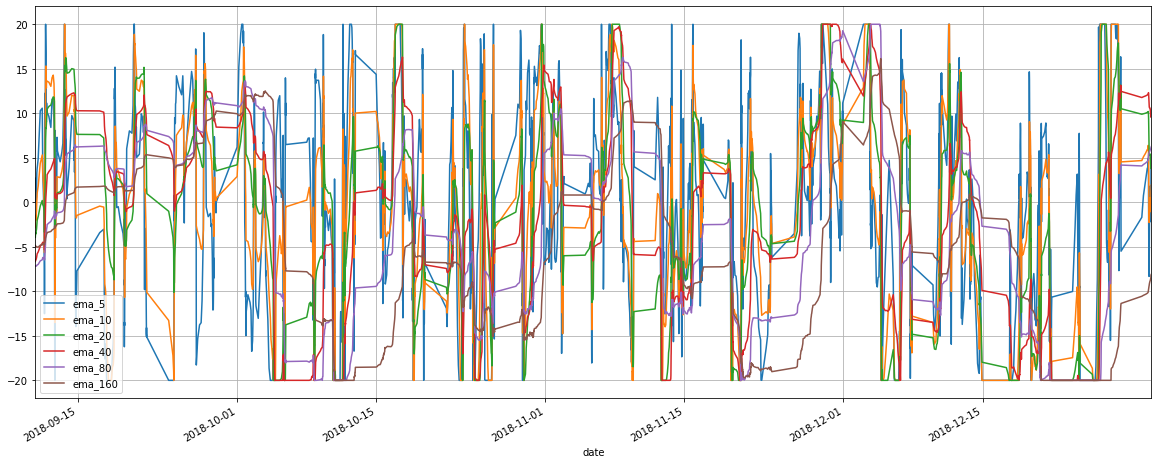

In [25]:
scaled_emas.plot(figsize=(20,8), grid=True);

In [26]:
scaled_emas

,ema_5,ema_10,ema_20,ema_40,ema_80,ema_160
date,,,,,,
2018-09-10 17:29:00,1.439019,-2.839322,-3.930751,-6.640644,-7.158575,-4.848316
2018-09-10 17:48:00,2.724862,-1.896429,-3.597061,-6.523339,-7.144115,-4.868813
2018-09-10 18:08:00,2.547875,-1.480853,-3.417353,-6.455784,-7.147312,-4.896360
2018-09-10 18:21:00,0.101681,-2.038155,-3.569821,-6.484282,-7.164402,-4.919961
2018-09-10 18:45:00,0.225024,-1.813531,-3.458331,-6.417344,-7.144689,-4.928417
...,...,...,...,...,...,...
2018-12-31 21:43:00,-1.130029,-0.778328,4.060531,9.819068,6.013769,-8.525894
2018-12-31 21:55:00,-1.704639,-1.055311,3.790559,9.670867,6.043697,-8.474277
2018-12-31 21:59:00,1.101406,-0.012884,3.947563,9.561580,6.052973,-8.278798


In [27]:
scaled_emas_combined = (scaled_emas * weights).sum(axis=1)

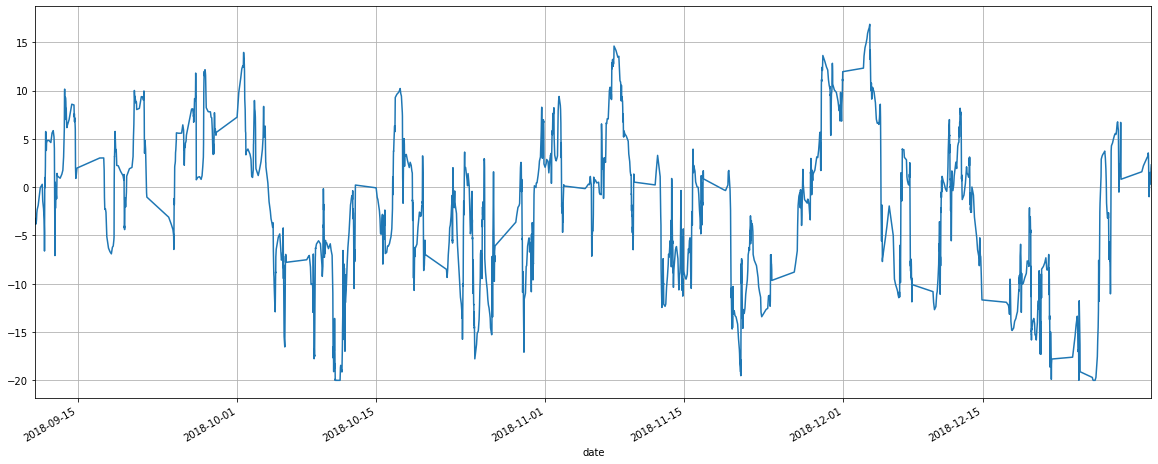

In [28]:
scaled_emas_combined.plot(figsize=(20,8), grid=True);

In [29]:
scaled_emas_combined.abs().mean()

6.924651427485244

In [30]:
scaled_emas_combined.abs().std()

4.8281805373455695

In [31]:
multiplier = target_vol/scaled_emas_combined.abs().std()
multiplier

1.2824344978417326

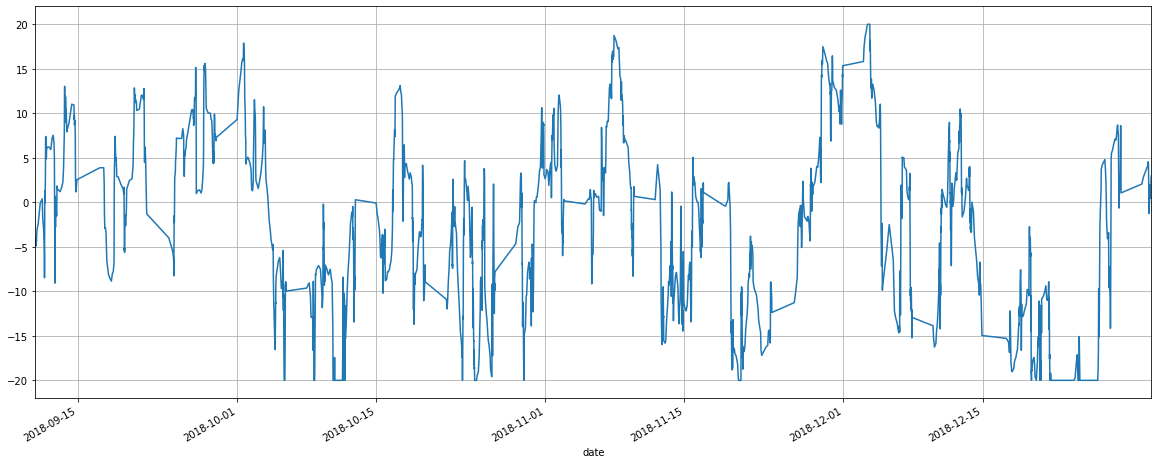

In [32]:
ema_forecast = (multiplier*scaled_emas_combined).clip(lower=-20, upper=20)
ema_forecast.plot(figsize=(20,8), grid=True);

In [33]:
ema_forecast.abs().mean(), ema_forecast.abs().std()

(8.715860102819592, 5.832792735999604)

In [34]:
contract_oos = contract_all.loc['20190101': '20191231']

In [35]:
data_oos = group_by_volume(contract_oos, avg_vol).set_index('date')
vols_oos = vol(data_oos, vol_lookback)
emas_oos = pd.DataFrame([ema(data_oos, p, smooth, vols_oos) for p in multi_periods]).T
scaled_emas_oos = (emas_oos * emas_adjustments).clip(lower=-20, upper=20)
scaled_emas_combined_oos = (scaled_emas_oos * weights).sum(axis=1)
ema_forecast_oos = (multiplier*scaled_emas_combined_oos).clip(lower=-20, upper=20)

In [36]:
weights

ema_5      0.201021
ema_10     0.153662
ema_20     0.136042
ema_40     0.134949
ema_80     0.152585
ema_160    0.221741
dtype: float64

In [37]:
emas_adjustments

ema_5      10.608442
ema_10      7.587018
ema_20      5.271691
ema_40      3.764452
ema_80      2.850397
ema_160     2.419842
dtype: float64

In [38]:
multiplier

1.2824344978417326

In [39]:
scaled_emas_oos.abs().mean()

ema_5       9.234063
ema_10      9.495391
ema_20      9.347459
ema_40      9.732289
ema_80     10.985165
ema_160    13.908483
dtype: float64

In [40]:
scaled_emas_oos.abs().std()

ema_5      6.278437
ema_10     6.368101
ema_20     6.265070
ema_40     5.950698
ema_80     6.357222
ema_160    6.263266
dtype: float64

In [41]:
scaled_emas_oos.corr()

,ema_5,ema_10,ema_20,ema_40,ema_80,ema_160
ema_5,1.000000,0.858394,0.557644,0.279222,0.125926,0.072460
ema_10,0.858394,1.000000,0.857903,0.548087,0.285636,0.152159
ema_20,0.557644,0.857903,1.000000,0.850839,0.545806,0.305841
ema_40,0.279222,0.548087,0.850839,1.000000,0.855091,0.572731
ema_80,0.125926,0.285636,0.545806,0.855091,1.000000,0.864494
ema_160,0.072460,0.152159,0.305841,0.572731,0.864494,1.000000


In [42]:
ema_forecast_oos.abs().mean(), ema_forecast_oos.std()

(9.808387502885278, 10.739061140140931)

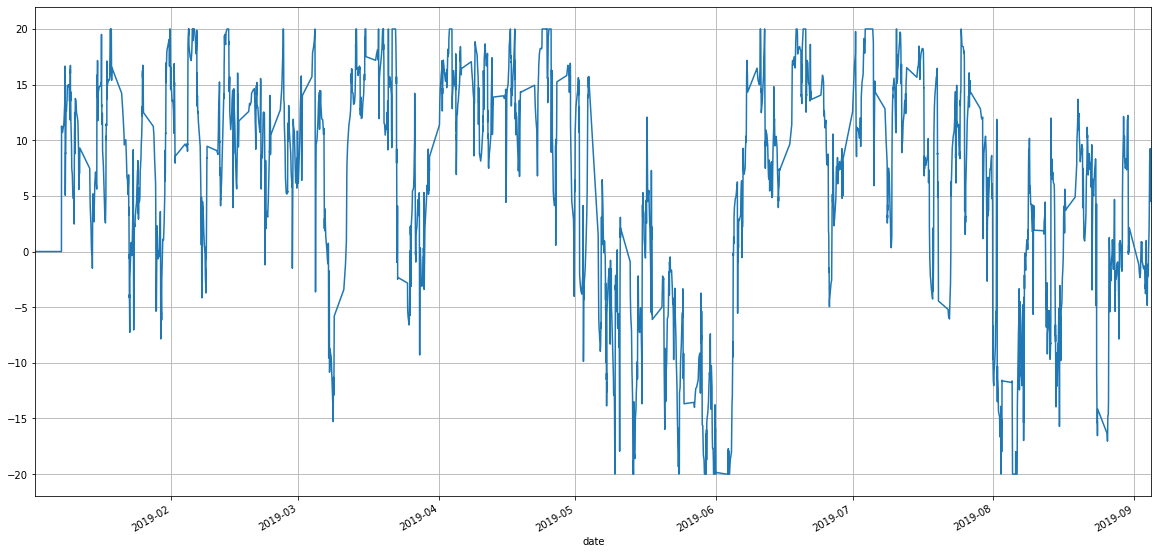

In [43]:
ema_forecast_oos.plot(figsize=(20,10), grid=True);

In [44]:
ema_forecast_oos

date
2019-01-02 02:48:00    0.000000
2019-01-02 03:50:00    0.000000
2019-01-02 06:16:00    0.000000
2019-01-02 08:53:00    0.000000
2019-01-02 09:24:00    0.000000
                         ...   
2019-09-04 16:59:00    4.484064
2019-09-04 17:24:00    4.605622
2019-09-04 17:41:00    5.391766
2019-09-04 18:15:00    5.754876
2019-09-04 18:31:00    5.918867
Length: 5777, dtype: float64

In [45]:
data_oos

,open,high,low,close,barCount,volume
date,,,,,,
2019-01-02 02:48:00,6349.50,6386.25,6344.00,6364.50,8729,12845
2019-01-02 03:50:00,6364.00,6366.50,6292.25,6303.50,9660,13120
2019-01-02 06:16:00,6303.50,6310.25,6258.75,6279.75,9608,13004
2019-01-02 08:53:00,6279.50,6282.50,6247.00,6253.00,9574,13019
2019-01-02 09:24:00,6252.75,6258.00,6171.50,6173.00,8943,13087
...,...,...,...,...,...,...
2019-09-04 16:59:00,7679.25,7683.75,7673.00,7682.00,6903,13405
2019-09-04 17:24:00,7682.00,7688.50,7679.50,7686.00,6961,14187
2019-09-04 17:41:00,7686.00,7702.75,7683.75,7700.00,6131,12957


In [62]:
data = data_oos.copy()
data['ema'] = ema_forecast_oos

In [63]:
data = data.loc['2019-01-07 21:02:00':]

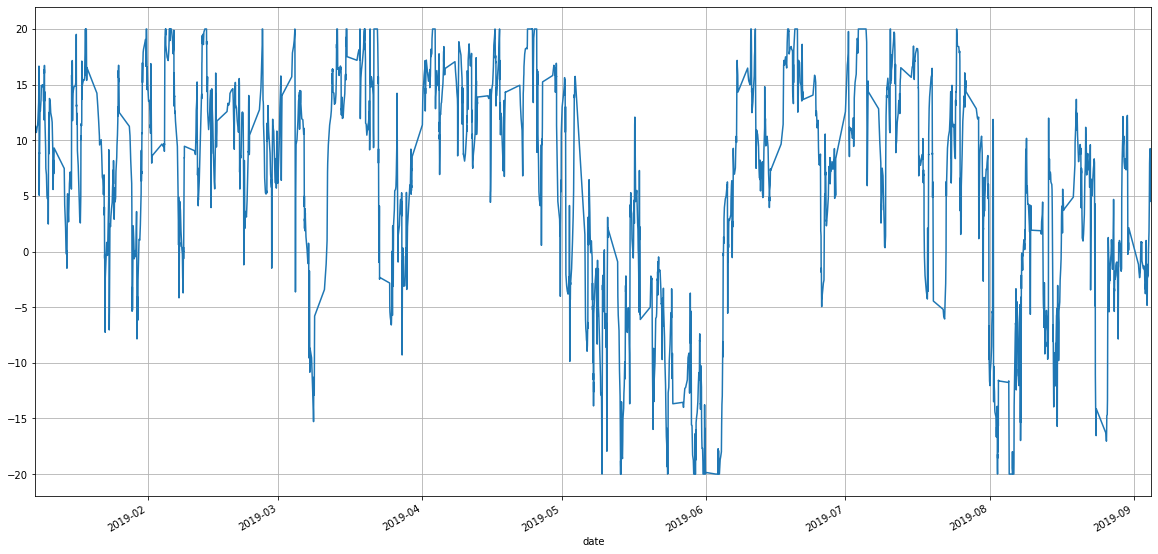

In [64]:
data.ema.plot(figsize=(20,10), grid=True);

In [65]:
stats = pd.DataFrame()
dailys = pd.DataFrame()
returns = pd.DataFrame()
for i in [0, 5, 6, 7, 10, 15, 17]: #12, 15, 20]:
    b = v_backtester(data.open, data.ema, i)
    r = perf_var(b, False)
    stats[i] = r.stats
    dailys[i] = r.daily.balance
    returns[i] = r.daily['returns']

In [66]:
stats

,0,5,6,7,10,15,17
Annual return,0.205842,0.202301,0.133495,0.0947209,0.097874,-0.0332032,0.0289915
Cumulative returns,0.137966,0.135657,0.090374,0.0644814,0.0665974,-0.0230456,0.0199292
Annual volatility,0.154347,0.136001,0.138325,0.133993,0.115544,0.0868174,0.0586533
Sharpe ratio,1.28989,1.42261,0.974677,0.741894,0.865471,-0.345946,0.516186
Calmar ratio,2.06604,3.11808,1.99762,1.34544,1.40363,-0.592436,1.06743
Stability,0.868457,0.860362,0.828461,0.729663,0.704915,0.00486489,0.394305
Max drawdown,-0.0996311,-0.0648799,-0.0668272,-0.0704012,-0.0697292,-0.0560452,-0.0271599
Omega ratio,1.23371,1.27156,1.17757,1.13083,1.17642,0.915387,1.17162
Sortino ratio,1.90027,2.27421,1.54315,1.18322,1.44187,-0.542997,1.09659
Skew,-0.0994232,0.311206,0.424885,0.605835,0.868343,1.29219,3.58318


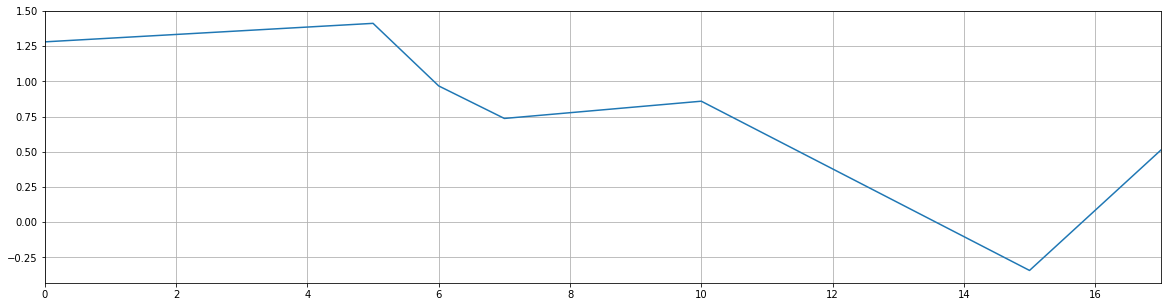

In [51]:
stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [52]:
returns.corr()

,0,5,6,7,10,15,17
0,1.000000,0.833656,0.795906,0.766145,0.700606,0.476198,0.440520
5,0.833656,1.000000,0.947482,0.921917,0.831160,0.590706,0.463535
6,0.795906,0.947482,1.000000,0.957470,0.854459,0.630920,0.480934
7,0.766145,0.921917,0.957470,1.000000,0.884783,0.636139,0.496206
10,0.700606,0.831160,0.854459,0.884783,1.000000,0.751888,0.570027
15,0.476198,0.590706,0.630920,0.636139,0.751888,1.000000,0.706873
17,0.440520,0.463535,0.480934,0.496206,0.570027,0.706873,1.000000


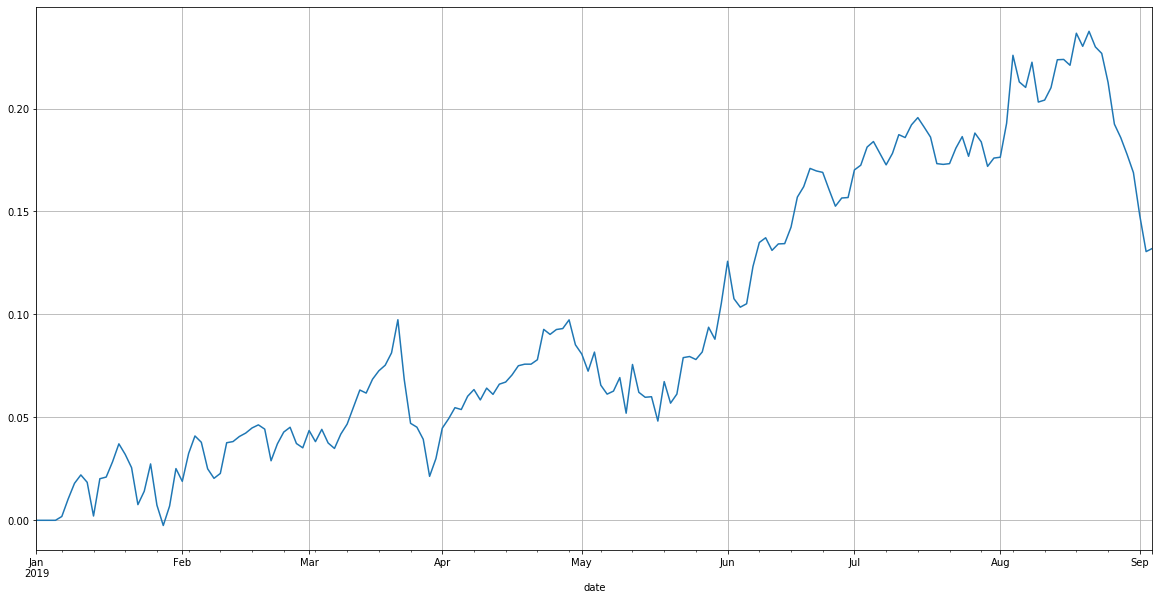

In [53]:
np.log(returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

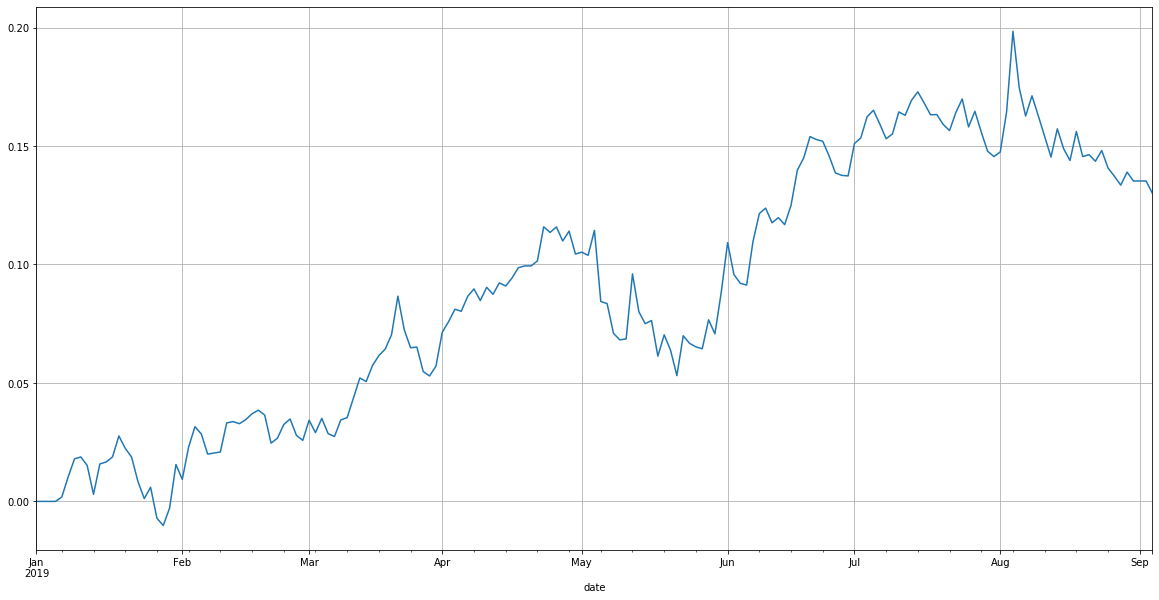

In [54]:
np.log(returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

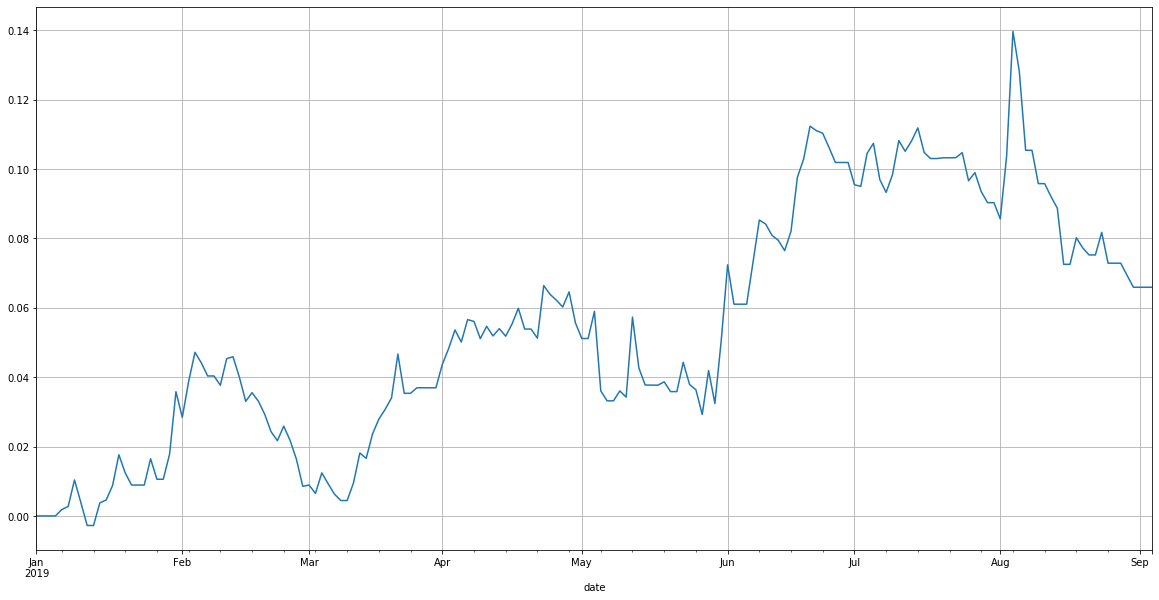

In [55]:
np.log(returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);